In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time
import dynesty

C:\Users\Admin\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [26]:
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9],dtype=float)
condition = (T90 > 0) & (fluence > 0)
X = np.vstack((np.log(T90[condition]), np.log(fluence[condition]))).T
print(X)

[[  3.62105554 -12.05648091]
 [  3.75543937 -12.60625175]
 [  3.33790253 -13.9830775 ]
 ...
 [  1.1429481  -17.5100862 ]
 [  5.34030348 -15.61671449]
 [  1.64557696 -12.85788596]]


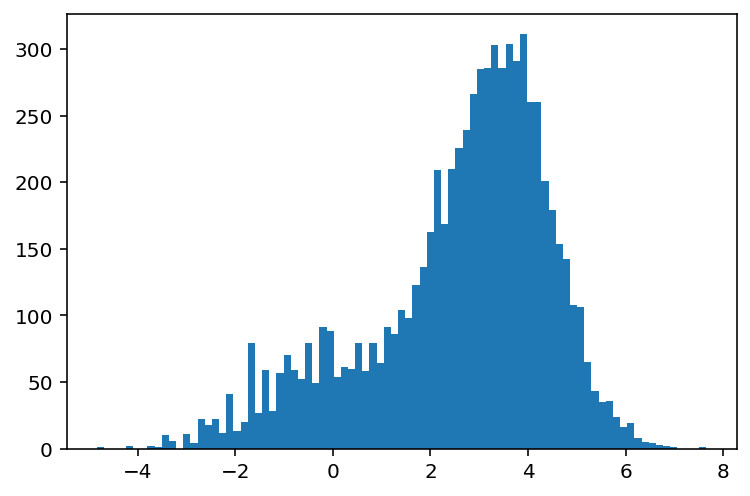

In [27]:
plt.hist(np.log(T90[condition]), bins = int(np.sqrt(len(T90[condition]))));

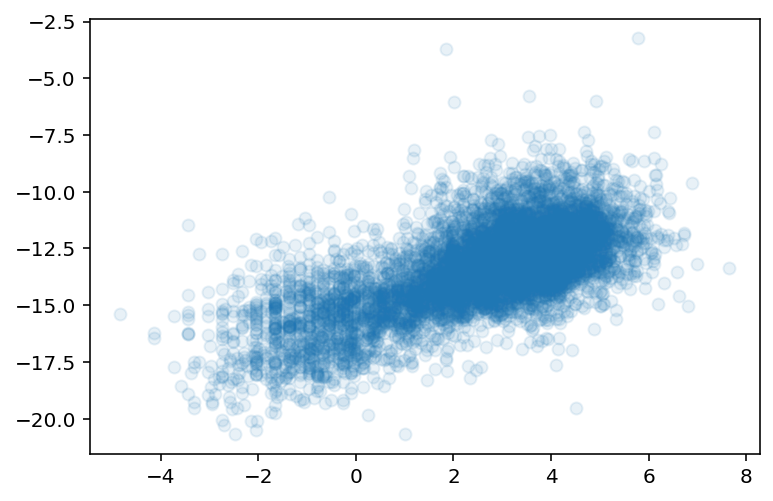

In [28]:
plt.scatter(np.log(T90[condition]), np.log(fluence[condition]), alpha = 0.1);

In [29]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with, but the number of clusters is an hyperparameter
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

# To get some information on these try:
# KMeans?
# help(clf)
plt.title('Clustering output');

TypeError: '<=' not supported between instances of 'str' and 'int'